# Loan Recommendation System
## POC - Proof Of Concept

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, expr, rank, count #countDistinct
from pyspark.sql import functions as F
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.linalg import Vectors  ##DenseMatrix
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import operator
import time

In [2]:
# from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder, CrossValidator
# from pyspark.ml.feature import VectorAssembler
# from pyspark.ml.feature import StringIndexer
# from pyspark.ml.feature import Normalizer
# from pyspark.sql.functions import mean
# from pyspark.sql.window import Window
# from pyspark.ml import Pipeline

In [3]:
spark = SparkSession.builder.appName('loan_recommendation_with_clusters').config("spark.driver.memory", "2g").getOrCreate()

In [4]:
# loans_df = spark.read.csv("RecommendData/df_temp_cluster_rating_condition_data.csv", inferSchema=True, header=True)
loans_df = spark.read.csv("Loan_Dataset/df_temp_cluster_rating_condition_data.csv", inferSchema=True, header=True)

loans_df.printSchema()

root
 |-- Id: string (nullable = true)
 |-- AccountID: string (nullable = true)
 |-- Number_Of_Loans_Granted__c: integer (nullable = true)
 |-- Num_Of_Loans_Paid__c: integer (nullable = true)
 |-- Purpose_of_Loan__c: string (nullable = true)
 |-- Total_Repayments__c: integer (nullable = true)
 |-- Amount: integer (nullable = true)
 |-- Term_in_Weeks__c: double (nullable = true)
 |-- Payment_Frequency__c: string (nullable = true)
 |-- StageName: string (nullable = true)
 |-- Applicant Age: integer (nullable = true)
 |-- summary_income: double (nullable = true)
 |-- summary_income_cv: double (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Cluster_result: integer (nullable = true)
 |-- userId: integer (nullable = true)
 |-- loanId: integer (nullable = true)
 |-- count: integer (nullable = true)



In [6]:
loans_df.select(["LoanIdFormat","Amount","Total_Repayments__c","Payment_Frequency__c","count"]).describe().show(10)

+-------+------------------+-----------------+-------------------+--------------------+------------------+
|summary|    Cluster_result|           Amount|Total_Repayments__c|Payment_Frequency__c|             count|
+-------+------------------+-----------------+-------------------+--------------------+------------------+
|  count|            481071|           481071|             481071|              481071|            481071|
|   mean| 99.84271760301493|861.5759420127174|  7.075398433911003|                NULL|1.6787376499518782|
| stddev|103.48255516647191|809.0576736930875|  4.136543039007542|                NULL|0.8991013265350534|
|    min|                -1|              100|                  1|         Fortnightly|                 0|
|    max|               735|             5000|                 45|              Weekly|                 8|
+-------+------------------+-----------------+-------------------+--------------------+------------------+



- Id: Likely a unique identifier for each data point.
- AccountID: Unique identifier for an account (possibly borrower).
- <h4>Loan-related features: </h4>
    -> Number_Of_Loans_Granted__c: Number of loans granted to the account.
    -> Num_Of_Loans_Paid__c: Number of loans paid by the account.
    -> Purpose_of_Loan__c: Category of the loan purpose (e.g., mortgage, education).
    -> Total_Repayments__c: Total amount repaid by the account.
    -> Amount: Loan amount requested.
    -> Term_in_Weeks__c: Loan term in weeks.
    -> Payment_Frequency__c: Frequency of loan repayment (e.g., weekly, monthly).
- <h4>Borrower-related features: </h4>
    ->
StageName: Current stage of the loan application (e.g., application, approved, rejected).    ->
Applicant Age: Age of the loan applicant    -> .
summary_income: Summary of applicant's incom    -> e.
summary_income_cv: Coefficient of variation of applicant's inco- <h4>me.
Location-related feat </h4>u    -> res:
city: City of the appli    -> cant.
state: State of the appl    -> icant.
Country: Country of the ap

- <h4>Additional features:</h4>
    ->
userId: Unique identifier for a user Account Id in Numericr).    ->
loanId: Unique identifier for a lo (Id or loanId in Numeric)an    -> .
counFeature related to the Ratings of the Loansnt    -> s.
LoanIdFormat: Format of the loan(Created LoanId using Clusters)nce).plicant.

In [7]:
loans_df.select(["LoanIdFormat","Amount","Total_Repayments__c","Payment_Frequency__c","count"]).show(10)

+------------+------+-------------------+--------------------+-----+
|LoanIdFormat|Amount|Total_Repayments__c|Payment_Frequency__c|count|
+------------+------+-------------------+--------------------+-----+
|           1|   500|                 10|              Weekly|    3|
|           1|   700|                 10|              Weekly|    3|
|           1|   800|                 10|              Weekly|    3|
|           1|   800|                 10|              Weekly|    3|
|           1|   800|                 10|              Weekly|    3|
|           1|   800|                 10|              Weekly|    3|
|           1|   800|                 10|              Weekly|    3|
|           1|   900|                 10|              Weekly|    3|
|           1|  1000|                 10|              Weekly|    3|
|           1|  1000|                 10|              Weekly|    3|
+------------+------+-------------------+--------------------+-----+
only showing top 10 rows



### Aggregating the loans per user (getting all loans for each user user)

In [8]:
user_loans = loans_df.groupby("userId").agg(F.collect_set("LoanIdFormat").alias("loans"))

In [9]:
Actual_loans_taken = user_loans.toPandas().to_dict('records')

### EDA - Exploratory Data Analysis 

<img src="https://editor.analyticsvidhya.com/uploads/24537Zoom-EDA.png" height=500 width="500" />

In [92]:
loans_df.select(["userId","LoanIdFormat","count","Amount","Total_Repayments__c","Number_Of_Loans_Granted__c","Num_Of_Loans_Paid__c"]).describe().show()

+-------+------------------+------------------+------------------+-----------------+-------------------+--------------------------+--------------------+
|summary|            userId|      LoanIdFormat|             count|           Amount|Total_Repayments__c|Number_Of_Loans_Granted__c|Num_Of_Loans_Paid__c|
+-------+------------------+------------------+------------------+-----------------+-------------------+--------------------------+--------------------+
|  count|            559151|            559151|            559151|           559151|             559151|                    559151|              559151|
|   mean|24735.774815747445| 4.527168868516734|1.6699120631099649|823.7755990778877| 7.0393507299459355|        11.901447015206983|   11.85676856519974|
| stddev|  15283.9297309685|2.7984778294162855| 0.895401428067646|766.2637755312184| 3.9631196080149467|         8.154409123854771|    8.27333904337744|
|    min|                 1|                 1|                 0|              10

#### Plotting the Frequnecy of Count(Ratings)

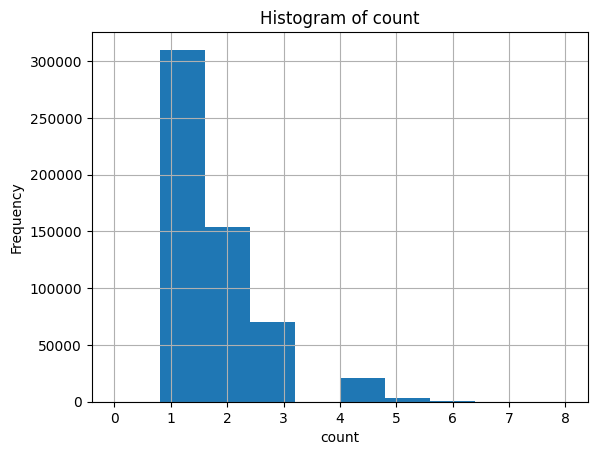

In [95]:
hist_data  = loans_df.toPandas()

hist_data['count'].hist()
plt.xlabel("count")
plt.ylabel("Frequency")
plt.title(f"Histogram of count")
plt.show()

#### Counting the No. of user & No. of Loans & No. of Explicitely Created Loan Id (Clustered Loan Id's)

In [96]:
# Count the number of unique items
num_unique_loan_id_format = loans_df.select('LoanIdFormat').distinct().count()
print(f"Number of unique loanId_format: {num_unique_loan_id_format}")

# Count the number of unique users
num_unique_id = loans_df.select('Id').distinct().count()
print(f"Number of unique Loan Id: {num_unique_id}")

Number of unique loanId_format: 20
Number of unique Loan Id: 407389


In [97]:
# Count the number of unique items
tmp = loans_df.select('userId').distinct().count()
print(f"Number of unique users: {tmp}")

Number of unique users: 59158


#### Values of count(Rating) Column.

In [14]:
print('Distinct values of count:')
loans_df.select('count').distinct().orderBy("count").show()

Distinct values of count:
+-----+
|count|
+-----+
|    0|
|    1|
|    2|
|    3|
|    4|
|    5|
|    6|
|    7|
|    8|
+-----+



### Converting the dataset into train test and validation split.

In [19]:
# we have to use 3 columns or features to put into the ALs Model.
loans_df.select(["LoanIdFormat","count","Amount"]).show(10)

+------------+-----+------+
|LoanIdFormat|count|Amount|
+------------+-----+------+
|           1|    3|   500|
|           1|    3|   700|
|           1|    3|   800|
|           1|    3|   800|
|           1|    3|   800|
|           1|    3|   800|
|           1|    3|   800|
|           1|    3|   900|
|           1|    3|  1000|
|           1|    3|  1000|
+------------+-----+------+
only showing top 10 rows



In [101]:
train, validation = loans_df.randomSplit([0.8, 0.2])
# train, validation, test = loans_df.randomSplit([0.8, 0.1, 0.1])
# # cache data
train.cache()
validation.cache()
# test.cache()

DataFrame[Id: string, AccountID: string, Number_Of_Loans_Granted__c: int, Num_Of_Loans_Paid__c: int, Purpose_of_Loan__c: string, Total_Repayments__c: int, Amount: int, Term_in_Weeks__c: double, Payment_Frequency__c: string, StageName: string, Applicant Age: int, summary_income: double, summary_income_cv: double, city: string, state: string, Country: string, userId: int, loanId: int, count: int, LoanIdFormat: int]

In [102]:
validation.select(["userId","loanId","LoanIdFormat","count","Amount","Total_Repayments__c"]).show()

+------+------+------------+-----+------+-------------------+
|userId|loanId|LoanIdFormat|count|Amount|Total_Repayments__c|
+------+------+------------+-----+------+-------------------+
|   138|    14|           1|    1|  1000|                 10|
| 25117|    33|           1|    3|   650|                 10|
|   160|    49|           6|    3|   300|                  2|
|   161|    50|           6|    1|   500|                  3|
| 23844|    56|           1|    1|   700|                 10|
|   177|    69|           6|    3|   400|                  4|
| 25097|    90|           1|    2|   200|                 10|
|   186|    99|           1|    1|   350|                 10|
|     5|   110|           6|    2|   250|                  5|
| 23556|   133|           1|    1|  1000|                 10|
|    17|   136|           1|    2|   300|                 10|
|    20|   145|           6|    1|   500|                  2|
|    21|   153|           6|    2|   350|                  4|
|    35|

In [103]:
loans_df.printSchema()

root
 |-- Id: string (nullable = true)
 |-- AccountID: string (nullable = true)
 |-- Number_Of_Loans_Granted__c: integer (nullable = true)
 |-- Num_Of_Loans_Paid__c: integer (nullable = true)
 |-- Purpose_of_Loan__c: string (nullable = true)
 |-- Total_Repayments__c: integer (nullable = true)
 |-- Amount: integer (nullable = true)
 |-- Term_in_Weeks__c: double (nullable = true)
 |-- Payment_Frequency__c: string (nullable = true)
 |-- StageName: string (nullable = true)
 |-- Applicant Age: integer (nullable = true)
 |-- summary_income: double (nullable = true)
 |-- summary_income_cv: double (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- userId: integer (nullable = true)
 |-- loanId: integer (nullable = true)
 |-- count: integer (nullable = true)
 |-- LoanIdFormat: integer (nullable = true)



In [104]:
def train_ALS(train_data, validation_data, num_iters, reg_param, ranks):
    """
    Grid Search Function to select the best model based on RMSE of hold-out data
    """
    # initial
    min_error = float('inf')
    best_rank = -1
    best_regularization = 0
    best_model = None
    for rank in ranks:
        for reg in reg_param:
            # Train the model using the training data
            als_model = ALS(maxIter=num_iters,regParam=reg, rank=rank,
                                        userCol='userId', itemCol='LoanIdFormat', ratingCol='count', seed=99,
                           coldStartStrategy="drop",nonnegative=True)
            model = als_model.fit(train_data)

            # Generate predictions on the test data
            predictions = model.transform(validation_data)
            predictions = predictions.withColumn("prediction", expr("CASE WHEN prediction < 0 THEN 0 WHEN prediction > 9 THEN 9 ELSE prediction END"))

            evaluator = RegressionEvaluator(metricName='rmse', labelCol='count', predictionCol='prediction')
            error = evaluator.evaluate(predictions)

            print('{} latent factors and regularization = {}: validation RMSE is {}'.format(rank, reg, error))
            if error < min_error:
                min_error = error
                best_rank = rank
                best_regularization = reg
                best_model = model
    print('\nThe best model has {} latent factors and regularization = {}'.format(best_rank, best_regularization))
    return best_model

In [105]:
# hyper-param config
num_iterations = 10
ranks = [8, 10, 20, 40, 60]
reg_params = [0.001, 0.01, 0.05, 0.1, 0.2]

# grid search and select best model
start_time = time.time()
final_model = train_ALS(train, validation, num_iterations, reg_params, ranks)

print ('Total Runtime: {:.2f} seconds'.format(time.time() - start_time))

8 latent factors and regularization = 0.001: validation RMSE is 0.020706025067694606
8 latent factors and regularization = 0.01: validation RMSE is 0.054385655069052796
8 latent factors and regularization = 0.05: validation RMSE is 0.07864480544984702
8 latent factors and regularization = 0.1: validation RMSE is 0.1014220329912908
8 latent factors and regularization = 0.2: validation RMSE is 0.19845778299390562
10 latent factors and regularization = 0.001: validation RMSE is 0.010387072532566972
10 latent factors and regularization = 0.01: validation RMSE is 0.04199438998594122
10 latent factors and regularization = 0.05: validation RMSE is 0.07019948270174567
10 latent factors and regularization = 0.1: validation RMSE is 0.09879898783941538
10 latent factors and regularization = 0.2: validation RMSE is 0.19882853381863105
20 latent factors and regularization = 0.001: validation RMSE is 0.12471789546455628
20 latent factors and regularization = 0.01: validation RMSE is 0.03702434684462

In [106]:
#OLD :  40 latent factors and regularization = 0.001
#NEW: The best model has 8 latent factors and regularization = 0.001

## Predicting the results from validation data

In [107]:
predictions = final_model.transform(validation)
# predictions = predictions.withColumn("prediction", expr("CASE WHEN prediction < 0 THEN 0 WHEN prediction > 9 THEN 9 ELSE prediction END"))

In [108]:
predictions.filter(predictions.userId == 10).select("userId", "loanId", "count", "LoanIdFormat", "prediction").show(20)

+------+------+-----+------------+----------+
|userId|loanId|count|LoanIdFormat|prediction|
+------+------+-----+------------+----------+
|    10|   932|    4|           6| 3.9845467|
|    10| 17247|    4|           6| 3.9845467|
|    10| 23209|    4|           6| 3.9845467|
|    10| 24267|    4|           1| 3.9819665|
|    10| 42894|    4|           1| 3.9819665|
|    10|120247|    4|           1| 3.9819665|
|    10|160635|    4|           1| 3.9819665|
|    10|230713|    4|           1| 3.9819665|
|    10|371513|    4|           1| 3.9819665|
|    10|371513|    4|           6| 3.9845467|
|    10|383859|    4|           2| 3.9786851|
+------+------+-----+------------+----------+



In [109]:
predictions.count()

111329

In [110]:
validation.count()

111859

## Error Evaluation with RMSE

<img src="https://docs.oracle.com/en/cloud/saas/planning-budgeting-cloud/pfusu/img/insights_rmse_formula.jpg" height="300" width="300" />

In [111]:

# Evaluate the model using Root Mean Squared Error (RMSE)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="count", predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) = " + str(rmse))


Root Mean Squared Error (RMSE) = 0.010387072532566972


## Recommendation of N users

In [112]:
userRecommends = final_model.recommendForAllUsers(5)
loanRecommends = final_model.recommendForAllItems(5)

In [113]:
userRecommends.printSchema()

root
 |-- userId: integer (nullable = false)
 |-- recommendations: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- LoanIdFormat: integer (nullable = true)
 |    |    |-- rating: float (nullable = true)



In [114]:
validation.printSchema()

root
 |-- Id: string (nullable = true)
 |-- AccountID: string (nullable = true)
 |-- Number_Of_Loans_Granted__c: integer (nullable = true)
 |-- Num_Of_Loans_Paid__c: integer (nullable = true)
 |-- Purpose_of_Loan__c: string (nullable = true)
 |-- Total_Repayments__c: integer (nullable = true)
 |-- Amount: integer (nullable = true)
 |-- Term_in_Weeks__c: double (nullable = true)
 |-- Payment_Frequency__c: string (nullable = true)
 |-- StageName: string (nullable = true)
 |-- Applicant Age: integer (nullable = true)
 |-- summary_income: double (nullable = true)
 |-- summary_income_cv: double (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- userId: integer (nullable = true)
 |-- loanId: integer (nullable = true)
 |-- count: integer (nullable = true)
 |-- LoanIdFormat: integer (nullable = true)



## ALS Model Evaluation

In [115]:
# Assuming you have a DataFrame 'validation_data' containing the ground truth interactions
# and a DataFrame 'recommendations' containing the top-N recommendations generated by the ALS model

# Join recommendations with ground truth data to identify true positives
true_positives = predictions.join(validation, ['userId', 'LoanIdFormat'], 'inner')

In [116]:
# Calculate the number of true positives per user
tp_per_user = true_positives.groupBy('userId').agg(expr('count(LoanIdFormat) as true_positives'))

In [117]:
 # Calculate the total number of relevant items per user in the ground truth data
relevant_per_user = validation.groupBy('userId').agg(expr('count(LoanIdFormat) as relevant'))

In [118]:
# Calculate Precision per user
precision_per_user = tp_per_user.join(relevant_per_user, 'userId', 'inner') \
    .selectExpr('userId', 'true_positives / relevant as precision')

In [119]:
# Calculate Recall per user
recall_per_user = tp_per_user.join(relevant_per_user, 'userId', 'inner') \
    .selectExpr('userId', 'true_positives / relevant as recall')

In [120]:
# Calculate F1-score per user
f1_score_per_user = precision_per_user.join(recall_per_user, 'userId', 'inner') \
    .selectExpr('userId', '(2 * precision * recall) / (precision + recall) as f1_score')

In [121]:
# Calculate overall Precision, Recall, and F1-score
overall_precision = precision_per_user.agg({'precision': 'avg'}).collect()[0][0]
overall_recall = recall_per_user.agg({'recall': 'avg'}).collect()[0][0]
overall_f1_score = f1_score_per_user.agg({'f1_score': 'avg'}).collect()[0][0]


In [122]:

# Print the results
print("Overall Precision:", overall_precision)
print("Overall Recall:", overall_recall)
print("Overall F1-score:", overall_f1_score)


Overall Precision: 1.843213951292485
Overall Recall: 1.843213951292485
Overall F1-score: 1.8432139512925023


## User Factors and Item Factors to calculate the cosine Similarity

In [123]:
userFactors = final_model.userFactors
itemFactors = final_model.itemFactors

In [124]:
userFactors.printSchema()

root
 |-- id: integer (nullable = false)
 |-- features: array (nullable = true)
 |    |-- element: float (containsNull = false)



In [125]:
userFactors.select("id","features").sort("id").show(10,truncate=False)

+---+-------------------------------------------------------------------------------------------------------+
|id |features                                                                                               |
+---+-------------------------------------------------------------------------------------------------------+
|1  |[0.41152278, 0.68797904, 0.0, 1.8847104, 1.6111966, 3.5177104, 2.4194748, 0.0, 3.48024, 0.035209756]   |
|2  |[0.26635957, 0.49407104, 0.0, 1.2624557, 1.0567558, 2.3362453, 1.6007545, 0.0, 2.3329155, 0.037628822] |
|3  |[0.124904685, 0.2666729, 0.0, 0.6305488, 0.5370493, 1.146011, 0.8014987, 0.0, 1.178046, 0.028614597]   |
|4  |[0.12503843, 0.26983488, 0.0, 0.6330847, 0.52934295, 1.1469394, 0.8008585, 0.0, 1.178747, 0.029212056] |
|5  |[0.25293696, 0.5337611, 0.0, 1.2659857, 1.0568147, 2.3013184, 1.600736, 0.0, 2.3536904, 0.056046523]   |
|6  |[0.12825137, 0.263192, 0.0, 0.63287205, 0.5272349, 1.1552886, 0.7997482, 0.0, 1.1744606, 0.026539823]  |
|7  |[0.12

In [126]:
itemFactors.select("id","features").sort("id").show(10,truncate=False)

+---+-----------------------------------------------------------------------------------------------------------------------------+
|id |features                                                                                                                     |
+---+-----------------------------------------------------------------------------------------------------------------------------+
|1  |[0.03231044, 0.060838636, 0.0, 0.15280296, 0.12649998, 0.28254625, 0.19274655, 0.0, 0.28195864, 0.0053077503]                |
|2  |[0.032821942, 0.054168675, 0.0, 0.15139672, 0.13002832, 0.28369233, 0.1944977, 0.0, 0.2796246, 0.0015188284]                 |
|3  |[0.009798056, 0.06945352, 0.078622356, 0.06240966, 0.34229618, 0.2787929, 0.06767103, 0.15232277, 0.3183133, 0.002801399]    |
|4  |[0.03361309, 0.05742784, 0.0, 0.15593146, 0.12523368, 0.28604463, 0.19283251, 0.0, 0.27713412, 9.212016E-4]                  |
|5  |[0.03833395, 0.0627036, 0.0, 0.15586229, 0.12456785, 0.28474355, 0.1924

In [127]:
import math

In [128]:
ur1,ur2,ur3,ur4,ur5,ur6,ur7,ur8 = [2.4307725, 7.9098544, 1.2765553, 0.024636148, 2.5557365, 3.767766, 0.072329044, 0.43128264]
ir1,ir2,ir3,ir4,ir5,ir6,ir7,ir8 = [0.10816363, 0.34584498, 0.053393964, 8.7923976E-4, 0.10868017, 0.16457365, 0.004021759, 0.024006216]
cosineSimily = ur1*ir1 +ur2*ir2 +ur3*ir3 +ur4*ir4 +ur5*ir5 +ur6*ir6 +ur7*ir7 +ur8*ir8
usernorm = math.sqrt(ur1**2 +ur2**2 +ur3**2 +ur4**2 +ur5**2 +ur6**2 +ur7**2 +ur8**2)
itemnorm = math.sqrt(ir1**2 +ir2**2 +ir3**2 +ir4**2 +ir5**2 +ir6**2 +ir7**2 +ir8**2)

print("Recommendation ::",cosineSimily/(usernorm*itemnorm))

Recommendation :: 0.9998678962582557


In [129]:
ur1,ur2,ur3,ur4,ur5,ur6,ur7,ur8 = [2.4307725, 7.9098544, 1.2765553, 0.024636148, 2.5557365, 3.767766, 0.072329044, 0.43128264]
ir1,ir2,ir3,ir4,ir5,ir6,ir7,ir8 = [0.112612374, 0.34390146, 0.03790004, 0.008411241, 0.09243223, 0.17332187, 0.008417915, 0.044041876]
cosineSimily = ur1*ir1 +ur2*ir2 +ur3*ir3 +ur4*ir4 +ur5*ir5 +ur6*ir6 +ur7*ir7 +ur8*ir8
usernorm = math.sqrt(ur1**2 +ur2**2 +ur3**2 +ur4**2 +ur5**2 +ur6**2 +ur7**2 +ur8**2)
itemnorm = math.sqrt(ir1**2 +ir2**2 +ir3**2 +ir4**2 +ir5**2 +ir6**2 +ir7**2 +ir8**2)

print("Recommendation ::",cosineSimily/(usernorm*itemnorm))


Recommendation :: 0.9956036270170981


In [130]:
final_model.userFactors.orderBy("id").collect()

[Row(id=1, features=[0.411522775888443, 0.6879790425300598, 0.0, 1.884710431098938, 1.6111966371536255, 3.5177104473114014, 2.4194748401641846, 0.0, 3.4802401065826416, 0.03520975634455681]),
 Row(id=2, features=[0.2663595676422119, 0.49407103657722473, 0.0, 1.262455701828003, 1.056755781173706, 2.33624529838562, 1.6007544994354248, 0.0, 2.3329155445098877, 0.03762882202863693]),
 Row(id=3, features=[0.12490468472242355, 0.26667290925979614, 0.0, 0.6305487751960754, 0.5370492935180664, 1.1460109949111938, 0.8014987111091614, 0.0, 1.1780459880828857, 0.028614597395062447]),
 Row(id=4, features=[0.12503843009471893, 0.26983487606048584, 0.0, 0.6330847144126892, 0.5293429493904114, 1.1469393968582153, 0.8008584976196289, 0.0, 1.1787470579147339, 0.02921205572783947]),
 Row(id=5, features=[0.2529369592666626, 0.5337610840797424, 0.0, 1.2659857273101807, 1.0568146705627441, 2.301318407058716, 1.6007360219955444, 0.0, 2.3536903858184814, 0.05604652315378189]),
 Row(id=6, features=[0.12825137

In [131]:
type(userFactors)

pyspark.sql.dataframe.DataFrame

In [132]:
userFactors.printSchema()

root
 |-- id: integer (nullable = false)
 |-- features: array (nullable = true)
 |    |-- element: float (containsNull = false)



In [133]:
userFactors.select(["id","Features"]).show(10,truncate=False)

+---+-------------------------------------------------------------------------------------------------------+
|id |Features                                                                                               |
+---+-------------------------------------------------------------------------------------------------------+
|10 |[0.5161984, 1.0461537, 0.0, 2.5312612, 2.10683, 4.6294312, 3.1978688, 0.0, 4.6935506, 0.10350048]      |
|20 |[0.12503843, 0.26983488, 0.0, 0.6330847, 0.52934295, 1.1469394, 0.8008585, 0.0, 1.178747, 0.029212056] |
|30 |[0.1312737, 0.24414107, 0.0, 0.629915, 0.53477687, 1.1633116, 0.80384934, 0.0, 1.1675291, 0.01622007]  |
|40 |[0.12503843, 0.26983488, 0.0, 0.6330847, 0.52934295, 1.1469394, 0.8008585, 0.0, 1.178747, 0.029212056] |
|50 |[0.12936598, 0.25174004, 0.0, 0.6288873, 0.53875786, 1.1576333, 0.8021934, 0.0, 1.1707959, 0.021528665]|
|60 |[0.12503843, 0.26983488, 0.0, 0.6330847, 0.52934295, 1.1469394, 0.8008585, 0.0, 1.178747, 0.029212056] |
|70 |[0.12

## Calculate cosine similarity:

### user-User Cosine Similarity code

<img src="https://datascience103579984.files.wordpress.com/2020/01/13-12.png" height="600" width="600" />

In [134]:
def cosine_similarity(u1, u2):
    """Calculates cosine similarity between two user factors."""
    # Convert lists to DenseVectors before performing operations
    u1_vector = Vectors.dense(u1)
    u2_vector = Vectors.dense(u2)
    return u1_vector.dot(u2_vector) / (u1_vector.norm(p=2) * u2_vector.norm(p=2))

In [135]:
# Example usage
user1_id = 10
user2_id = 20
user1_factors = userFactors.filter(userFactors.id == user1_id ).collect()[0][1]
user2_factors = userFactors.filter(userFactors.id == user2_id ).collect()[0][1]
# user1_factors = userFactors.to_dense().rdd.filter(lambda x: x[0] == user1_id).collect()[0][1]
# user2_factors = userFactors.to_dense().rdd.filter(lambda x: x[0] == user2_id).collect()[0][1]
similarity = cosine_similarity(user1_factors, user2_factors)
print(f"Cosine similarity between users {user1_id} and {user2_id}: {similarity}")


Cosine similarity between users 10 and 20: 0.9999706272204698


### User-Item Cosine Similarity code

In [137]:
# Example usage
user1_id = 10
item_id = 1
user_factors = userFactors.filter(userFactors.id == user1_id ).collect()[0][1]
item_factors = itemFactors.filter(itemFactors.id == item_id ).collect()[0][1]

user_item_similarity = cosine_similarity(user_factors, item_factors)
print(f"Cosine similarity between users {user1_id} and {item_id}: {user_item_similarity}")

Cosine similarity between users 10 and 1: 0.9999598407335776


###  Cosine Similarity of user 10 with all Loans

In [138]:
TopCosineLoanforuser10 = []
for item in range(itemFactors.count()):
    item_id = itemFactors.select("Id").sort("Id").take(itemFactors.count())[item][0]
    user1_id = 10
    user_factors = userFactors.filter(userFactors.id == user1_id ).collect()[0][1]
    item_factors = itemFactors.filter(itemFactors.id == item_id ).collect()[0][1]


    user_item_similarity = cosine_similarity(user_factors, item_factors)
    TopCosineLoanforuser10.append({"userID":user1_id,"LoanId":item_id,"CosineSimilarity":user_item_similarity})

In [139]:
sorted_Cosine_list = sorted(TopCosineLoanforuser10, key=operator.itemgetter('CosineSimilarity'),reverse=True)
sorted_Cosine_list

[{'userID': 10, 'LoanId': 6, 'CosineSimilarity': 0.9999706273465713},
 {'userID': 10, 'LoanId': 1, 'CosineSimilarity': 0.9999598407335776},
 {'userID': 10, 'LoanId': 2, 'CosineSimilarity': 0.9996885796066601},
 {'userID': 10, 'LoanId': 5, 'CosineSimilarity': 0.9996751916125634},
 {'userID': 10, 'LoanId': 7, 'CosineSimilarity': 0.9996697402782446},
 {'userID': 10, 'LoanId': 4, 'CosineSimilarity': 0.9996616732840711},
 {'userID': 10, 'LoanId': 19, 'CosineSimilarity': 0.9995216021032562},
 {'userID': 10, 'LoanId': 16, 'CosineSimilarity': 0.9992673792938848},
 {'userID': 10, 'LoanId': 10, 'CosineSimilarity': 0.9992668844119118},
 {'userID': 10, 'LoanId': 18, 'CosineSimilarity': 0.9989784432507619},
 {'userID': 10, 'LoanId': 8, 'CosineSimilarity': 0.9989064077457346},
 {'userID': 10, 'LoanId': 12, 'CosineSimilarity': 0.9989031567531845},
 {'userID': 10, 'LoanId': 11, 'CosineSimilarity': 0.998202382299212},
 {'userID': 10, 'LoanId': 20, 'CosineSimilarity': 0.9972463943575983},
 {'userID': 10

In [139]:
df_with_new_column = df.withColumn("id_plus_119", col("id") + 119)

### Cosine Similarity of first 10 users with all loans

In [151]:
# Collect all user factors into a dictionary
user_factors_dict = userFactors.select("id", "features").rdd.collectAsMap()

# Broadcast the user factors dictionary to all workers
broadcast_user_factors = spark.sparkContext.broadcast(user_factors_dict)

# Collect all item factors into a dictionary
item_factors_dict = itemFactors.select("id", "features").rdd.collectAsMap()

# Broadcast the item factors dictionary to all workers
broadcast_item_factors = spark.sparkContext.broadcast(item_factors_dict)

In [152]:
# Initially the code is like this !!
def cosine_similarity(u1, u2):
    """Calculates cosine similarity between two user factors."""
    # Convert lists to DenseVectors before performing operations
    u1_vector = Vectors.dense(u1)
    u2_vector = Vectors.dense(u2)
    return u1_vector.dot(u2_vector) / (u1_vector.norm(p=2) * u2_vector.norm(p=2))

def cosine_similarity(vec1, vec2):
    dot_product = sum(v1 * v2 for v1, v2 in zip(vec1, vec2))
    magnitude1 = sum(v ** 2 for v in vec1) ** 0.5
    magnitude2 = sum(v ** 2 for v in vec2) ** 0.5
    return dot_product / (magnitude1 * magnitude2)

In [157]:


# Initialize list to store recommendations
CosineSilty_first10 = []
starttime = time.time()
Nusers = 25000

# Iterate over users
for userId in range(1, Nusers):
    user_factors = broadcast_user_factors.value.get(userId)
    if user_factors:
        TopCosineLoanforuser10 = []
        # Iterate over items
        for item_id, item_factors in broadcast_item_factors.value.items():
            user_item_similarity = cosine_similarity(user_factors, item_factors)
            TopCosineLoanforuser10.append({item_id: user_item_similarity})

        # Sort recommendations based on similarity
        Recomnd_loans = sorted(TopCosineLoanforuser10, key=lambda x: list(x.values())[0], reverse=True)
        CosineSilty_first10.append({"UserId": userId, "Recommendation": Recomnd_loans})

endtime = time.time()
runtime_hours = (endtime - starttime) / 3600
print(f"The time taken to run code for {Nusers} users is : {runtime_hours} hours")

The time taken to run code for 25000 users is : 0.003167028890715705 hours


In [159]:
# Define a function to extract top-N recommendations
def extract_top_n_recommendations(recommendations_data, n=2500):
    top_n_recommendations = [{'userId': user_recommendation['UserId'],
                              'Recommendation': [list(rec.keys())[0] for rec in user_recommendation['Recommendation'][:n]]}
                             for user_recommendation in recommendations_data]
    return top_n_recommendations

# Extract top-N recommendations
starttime = time.time()
top_n_recommendations = extract_top_n_recommendations(CosineSilty_first10, n=5)
endtime = time.time()
runtime_hours = (endtime - starttime) / 3600


In [161]:
top_n_recommendations

[{'userId': 1, 'Recommendation': [2, 19, 1, 4, 16]},
 {'userId': 2, 'Recommendation': [1, 2, 4, 6, 5]},
 {'userId': 3, 'Recommendation': [6, 1, 7, 2, 5]},
 {'userId': 4, 'Recommendation': [6, 1, 7, 2, 5]},
 {'userId': 5, 'Recommendation': [6, 1, 7, 2, 5]},
 {'userId': 6, 'Recommendation': [6, 1, 7, 2, 5]},
 {'userId': 7, 'Recommendation': [6, 1, 7, 2, 5]},
 {'userId': 8, 'Recommendation': [2, 1, 4, 19, 5]},
 {'userId': 9, 'Recommendation': [6, 1, 7, 2, 5]},
 {'userId': 10, 'Recommendation': [6, 1, 2, 5, 7]},
 {'userId': 11, 'Recommendation': [6, 1, 7, 2, 5]},
 {'userId': 12, 'Recommendation': [6, 1, 7, 2, 5]},
 {'userId': 13, 'Recommendation': [1, 6, 4, 2, 5]},
 {'userId': 14, 'Recommendation': [1, 2, 6, 4, 19]},
 {'userId': 15, 'Recommendation': [1, 2, 4, 6, 5]},
 {'userId': 16, 'Recommendation': [1, 6, 2, 7, 4]},
 {'userId': 17, 'Recommendation': [1, 2, 4, 6, 5]},
 {'userId': 18, 'Recommendation': [1, 6, 4, 2, 5]},
 {'userId': 19, 'Recommendation': [6, 1, 7, 2, 5]},
 {'userId': 20, '

In [162]:
Actual_loans_taken =  dict_lopo

In [163]:
# Function to recommend top N loans not taken by the user
def recommend_loans_not_taken(user_id, recommendations, actual_loans_taken, top_n):
    taken_loans = set(actual_loans_taken.get(user_id, []))
    recommended_loans = []
    for rec in recommendations:
        loan_id = list(rec.keys())[0]
        if loan_id not in taken_loans:
            recommended_loans.append(loan_id)
            if len(recommended_loans) == top_n:
                break
    return recommended_loans

# Define a dictionary to store actual loans taken by each user
actual_loans_taken_dict = {record['userId']: record['loans'] for record in Actual_loans_taken}

# Create a list to store recommendations for each user
recommendations_for_users = []

# Iterate over each user
for rec_user in CosineSilty_first10:
    user_id = rec_user['UserId']
    recommendations = rec_user['Recommendation']
    # Recommend top N loans not taken by the user
    recommended_loans = recommend_loans_not_taken(user_id, recommendations, actual_loans_taken_dict, top_n=5)
    recommendations_for_users.append({'UserId': user_id, 'Recommendations': recommended_loans})



##  Calculate centered cosine similarity:

In [167]:
def centered_cosine_similarity(u, v):
    """ Calculate centered cosine similarity between two vectors u and v. """
    # Calculate mean of u and v
    mean_u = sum(u) / len(u)
    mean_v = sum(v) / len(v)

    # Subtract mean from u and v
    centered_u = Vectors.dense([x - mean_u for x in u])
    centered_v = Vectors.dense([x - mean_v for x in v])

    # Calculate centered cosine similarity
    dot_product = float(centered_u.dot(centered_v))
    norm_u = float(centered_u.norm(2))
    norm_v = float(centered_v.norm(2))

    centered_sim = dot_product / (norm_u * norm_v)
    return centered_sim


### User-User Centerd Cosine Similarity code

In [168]:
# Example usage
user1_id = 10
user2_id = 20
user1_factors = userFactors.filter(userFactors.id == user1_id ).collect()[0][1]
user2_factors = userFactors.filter(userFactors.id == user2_id ).collect()[0][1]
similarity = centered_cosine_similarity(user1_factors, user2_factors)
print(f"Centered Cosine similarity between users {user1_id} and {user2_id}: {similarity}")


Centered Cosine similarity between users 10 and 20: 0.9999402403372109


### User-Item Centerd Cosine Similarity code

In [169]:
# Example usage
user1_id = 10
item_id = 1
user2_factors = userFactors.filter(userFactors.id == user1_id ).collect()[0][1]
item3_factors = itemFactors.filter(itemFactors.id == item_id ).collect()[0][1]

user_item_similarity = centered_cosine_similarity(user2_factors, item3_factors)
print(f"Centered Cosine similarity between users {user1_id} and Item {item_id}: {user_item_similarity}")


Centered Cosine similarity between users 10 and Item 1: 0.999919030089421


### Cosine Similarity of user 10 with all Loans

In [170]:
topNLoanforuser10 = []
for item in range(itemFactors.count()):
    item_id = itemFactors.select("Id").sort("Id").take(itemFactors.count())[item][0]
    user1_id = 10
    user_factors = userFactors.filter(userFactors.id == user1_id ).collect()[0][1]
    item_factors = itemFactors.filter(itemFactors.id == item_id ).collect()[0][1]


    user_item_similarity = centered_cosine_similarity(user_factors, item_factors)
    topNLoanforuser10.append({"userID":user1_id,"LoanId":item_id,"CenteredSimilarity":user_item_similarity})

In [171]:
sorted_list = sorted(topNLoanforuser10, key=operator.itemgetter('CenteredSimilarity'),reverse=True)
sorted_list

[{'userID': 10, 'LoanId': 6, 'CenteredSimilarity': 0.9999402406065981},
 {'userID': 10, 'LoanId': 1, 'CenteredSimilarity': 0.999919030089421},
 {'userID': 10, 'LoanId': 2, 'CenteredSimilarity': 0.9994108968476482},
 {'userID': 10, 'LoanId': 4, 'CenteredSimilarity': 0.9993263821998536},
 {'userID': 10, 'LoanId': 5, 'CenteredSimilarity': 0.9992980136547397},
 {'userID': 10, 'LoanId': 7, 'CenteredSimilarity': 0.9992872489158106},
 {'userID': 10, 'LoanId': 19, 'CenteredSimilarity': 0.9990274659611021},
 {'userID': 10, 'LoanId': 10, 'CenteredSimilarity': 0.9989727778694254},
 {'userID': 10, 'LoanId': 16, 'CenteredSimilarity': 0.9984485690104313},
 {'userID': 10, 'LoanId': 18, 'CenteredSimilarity': 0.9978390597058722},
 {'userID': 10, 'LoanId': 8, 'CenteredSimilarity': 0.9977784354822424},
 {'userID': 10, 'LoanId': 12, 'CenteredSimilarity': 0.997642615833819},
 {'userID': 10, 'LoanId': 11, 'CenteredSimilarity': 0.9964039818046083},
 {'userID': 10, 'LoanId': 15, 'CenteredSimilarity': 0.994473

In [172]:
sorted(topNLoanforuser10, key=operator.itemgetter('LoanId') )

[{'userID': 10, 'LoanId': 1, 'CenteredSimilarity': 0.999919030089421},
 {'userID': 10, 'LoanId': 2, 'CenteredSimilarity': 0.9994108968476482},
 {'userID': 10, 'LoanId': 3, 'CenteredSimilarity': 0.6387085505479762},
 {'userID': 10, 'LoanId': 4, 'CenteredSimilarity': 0.9993263821998536},
 {'userID': 10, 'LoanId': 5, 'CenteredSimilarity': 0.9992980136547397},
 {'userID': 10, 'LoanId': 6, 'CenteredSimilarity': 0.9999402406065981},
 {'userID': 10, 'LoanId': 7, 'CenteredSimilarity': 0.9992872489158106},
 {'userID': 10, 'LoanId': 8, 'CenteredSimilarity': 0.9977784354822424},
 {'userID': 10, 'LoanId': 9, 'CenteredSimilarity': 0.5918840137673157},
 {'userID': 10, 'LoanId': 10, 'CenteredSimilarity': 0.9989727778694254},
 {'userID': 10, 'LoanId': 11, 'CenteredSimilarity': 0.9964039818046083},
 {'userID': 10, 'LoanId': 12, 'CenteredSimilarity': 0.997642615833819},
 {'userID': 10, 'LoanId': 13, 'CenteredSimilarity': 0.21176130804642346},
 {'userID': 10, 'LoanId': 14, 'CenteredSimilarity': 0.8410442

In [ ]:
predictions.printSchema()

root
 |-- Id: string (nullable = true)
 |-- AccountID: string (nullable = true)
 |-- Number_Of_Loans_Granted__c: integer (nullable = true)
 |-- Num_Of_Loans_Paid__c: integer (nullable = true)
 |-- Purpose_of_Loan__c: string (nullable = true)
 |-- Total_Repayments__c: integer (nullable = true)
 |-- Amount: integer (nullable = true)
 |-- Term_in_Weeks__c: double (nullable = true)
 |-- Payment_Frequency__c: string (nullable = true)
 |-- StageName: string (nullable = true)
 |-- Applicant Age: integer (nullable = true)
 |-- summary_income: double (nullable = true)
 |-- summary_income_cv: double (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- userId: integer (nullable = true)
 |-- loanId: integer (nullable = true)
 |-- count: integer (nullable = true)
 |-- LoanIdFormat: integer (nullable = true)
 |-- prediction: float (nullable = false)



In [ ]:
predictions.select(["LoanIdFormat","loanId","userId","Amount","Total_Repayments__c","count","prediction"]).show(11)

+------------+------+------+------+-------------------+-----+----------+
|LoanIdFormat|loanId|userId|Amount|Total_Repayments__c|count|prediction|
+------------+------+------+------+-------------------+-----+----------+
|           1|  1859|  2366|   500|                 10|    1| 0.9933492|
|           1| 18371|  4818|   600|                 10|    2| 1.9914738|
|           1| 24830|  1342|   500|                 10|    1| 0.9981674|
|           1| 39048|  1238|   500|                 10|    3|  2.984103|
|           1| 44319| 19984|   500|                  6|    3|  2.992899|
|           1| 44367| 16503|   300|                  6|    3| 2.9956226|
|           1| 44446| 15846|   200|                  6|    3|  2.991486|
|           1| 48006| 20683|   600|                 10|    1| 0.9933492|
|           1| 49432| 18866|   500|                  6|    1| 0.9981674|
|           1| 50698| 17420|   750|                 10|    1| 0.9965345|
|           1| 51505| 15447|   400|                

In [ ]:
predictions.select("prediction","LoanIdFormat").describe().show()

+-------+------------------+------------------+
|summary|        prediction|      LoanIdFormat|
+-------+------------------+------------------+
|  count|            111352|            111352|
|   mean| 1.661863417419055| 4.518930957683741|
| stddev|0.8937703516935817|2.7881530111682316|
|    min|               0.0|                 1|
|    max|         7.9761477|                20|
+-------+------------------+------------------+



In [ ]:
evaluator = RegressionEvaluator(metricName='rmse', labelCol='count', predictionCol='prediction')
error = evaluator.evaluate(predictions)

In [ ]:
print(f"The RMSE for the above m0odel is : {error}")  # o.463

The RMSE for the above mnodel is : 0.028842204161434074


In [ ]:
userRecommends = final_model.recommendForAllUsers(5)
loanRecommends = final_model.recommendForAllItems(5)

In [ ]:
loanRecommends.printSchema()

root
 |-- LoanIdFormat: integer (nullable = false)
 |-- recommendations: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- userId: integer (nullable = true)
 |    |    |-- rating: float (nullable = true)



In [ ]:
loanRecommends.select(["LoanIdFormat","recommendations.userId","recommendations.rating"]).show(10,truncate=False)

+------------+----------------------------------+-------------------------------------------------------+
|LoanIdFormat|userId                            |rating                                                 |
+------------+----------------------------------+-------------------------------------------------------+
|20          |[1832, 24495, 24531, 24991, 15933]|[7.950424, 7.0113587, 6.9573717, 6.0000634, 5.9925804] |
|10          |[1832, 24713, 24608, 24303, 24495]|[8.555681, 7.465768, 7.3844924, 7.339622, 7.0376883]   |
|1           |[1832, 24495, 24531, 15933, 24418]|[7.9761477, 7.0013914, 6.9772563, 6.0103855, 6.0089397]|
|11          |[1832, 24495, 24531, 15933, 24418]|[9.5949135, 8.382941, 8.35992, 7.275463, 7.274435]     |
|12          |[1832, 24495, 24531, 24991, 24301]|[7.973118, 7.0685134, 6.977419, 6.0400486, 6.019967]   |
|2           |[1832, 24495, 24531, 15933, 24418]|[7.9706793, 7.006312, 6.973244, 6.006671, 6.005226]    |
|13          |[1832, 24713, 24608, 24303, 2449

In [ ]:
userRecommends.printSchema()

root
 |-- userId: integer (nullable = false)
 |-- recommendations: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- LoanIdFormat: integer (nullable = true)
 |    |    |-- rating: float (nullable = true)



In [ ]:
userRecommends.filter(userRecommends.userId == 10 ).show(vertical=True,truncate=False)

-RECORD 0--------------------------------------------------------------------------------------------
 userId          | 10                                                                                
 recommendations | [{11, 4.818267}, {19, 4.042764}, {5, 4.033351}, {10, 4.0070896}, {12, 3.9973161}] 



In [ ]:
userRecommends.select(["userId","recommendations.LoanIdFormat","recommendations.rating"]).show(10,truncate=False)

+------+-------------------+--------------------------------------------------------+
|userId|LoanIdFormat       |rating                                                  |
+------+-------------------+--------------------------------------------------------+
|1     |[11, 19, 10, 5, 4] |[3.483842, 2.9951677, 2.9910934, 2.986418, 2.9808848]   |
|6     |[11, 19, 5, 10, 12]|[1.2100239, 1.0132257, 1.0107574, 1.0031507, 1.0014443] |
|12    |[11, 19, 5, 12, 10]|[2.4086132, 2.0269725, 2.0201576, 2.0100853, 2.0080824] |
|13    |[11, 19, 5, 10, 12]|[1.1989177, 1.0090533, 1.006838, 1.0012228, 0.99791485] |
|16    |[11, 19, 12, 5, 10]|[1.1825534, 1.0075336, 1.0040952, 1.0034789, 1.002596]  |
|22    |[11, 19, 5, 10, 1] |[1.1965677, 1.0075513, 1.0053955, 1.0006418, 0.99691176]|
|26    |[11, 19, 5, 10, 1] |[1.1896594, 1.0058196, 1.0035554, 0.99995625, 0.9963331]|
|27    |[11, 19, 5, 10, 1] |[1.1919556, 1.0058408, 1.0038042, 1.0001444, 0.99620336]|
|28    |[11, 10, 19, 5, 1] |[1.1703922, 0.99830914, 0.

In [ ]:
LoanRecommendation =  [{11, 4.818267}, {19, 4.042764}, {5, 4.033351}, {10, 4.0070896}, {12, 3.9973161}]

In [ ]:
loanRecommend_user_10 = [{"userID":10,"LoanId":loanI,"Ratings":ratin} for loanI,ratin in LoanRecommendation]

In [ ]:
sorted(loanRecommend_user_10, key=operator.itemgetter('Ratings'),reverse=True )

[{'userID': 10, 'LoanId': 3.9973161, 'Ratings': 12},
 {'userID': 10, 'LoanId': 4.033351, 'Ratings': 5},
 {'userID': 10, 'LoanId': 11, 'Ratings': 4.818267},
 {'userID': 10, 'LoanId': 19, 'Ratings': 4.042764},
 {'userID': 10, 'LoanId': 10, 'Ratings': 4.0070896}]

In [ ]:
loanRecommend_user_10

[{'userID': 10, 'LoanId': 11, 'Ratings': 4.818267},
 {'userID': 10, 'LoanId': 19, 'Ratings': 4.042764},
 {'userID': 10, 'LoanId': 4.033351, 'Ratings': 5},
 {'userID': 10, 'LoanId': 10, 'Ratings': 4.0070896},
 {'userID': 10, 'LoanId': 3.9973161, 'Ratings': 12}]